### (2/5) Learning how Optical Flow works via Horn Schunck Algorithm

https://en.wikipedia.org/wiki/Horn%E2%80%93Schunck_method

https://www.youtube.com/watch?v=kJouUVZ0QqU&t=33m19s

In [170]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

FRAME1 = "data/tennis492.jpg"
FRAME2 = "data/tennis493.jpg"
frame1 = cv2.imread(FRAME1, 0)
frame2 = cv2.imread(FRAME2, 0)

In [172]:
#https://www.youtube.com/watch?v=kJouUVZ0QqU&t=3098s
def calcOpticalFlowHornSchunck(frame1, frame2, alpha=1, iterations=10):
    
    SOBEL_X_OPERATOR = [
        (-1, 0, 1),
        (-2, 0, 2),
        (-1, 0, 1)
    ]

    SOBEL_Y_OPERATOR = np.transpose(SOBEL_X_OPERATOR)

    AVERAGE_OPERATOR = [
        (0, 0.25, 0),
        (0.25, 0, 0.25),
        (0, 0.25, 0)
    ]
    
    u = np.zeros(frame1.shape)
    v = np.zeros(frame2.shape)
    
    def conv(a, operator, boundary='symm', mode='same'):
        return convolve2d(a, operator, boundary=boundary, mode=mode)
    
    fx = conv(frame1, SOBEL_X_OPERATOR) + conv(frame2, SOBEL_X_OPERATOR)
    fy = conv(frame1, SOBEL_Y_OPERATOR) + conv(frame2, SOBEL_Y_OPERATOR)
    ft = frame1-frame2
    D = alpha + fx**2 + fy**2
    
    def uav():
        return conv(u, AVERAGE_OPERATOR)
    def vav():
        return conv(v, AVERAGE_OPERATOR)
    def P():
        return np.multiply(fx, uav()) + np.multiply(fy, vav()) + ft
    def P_D():
        return np.divide(P(),D)
    
    for i in range(iterations):
        u = uav() - np.multiply(fx, P_D())
        v = vav() - np.multiply(fy, P_D())
        
    return (u,v)

In [173]:
def showFlow(frame1, frame2, alpha, iterations):
    
    frame1_smooth = cv2.resize(frame1, (512,512))
    frame2_smooth = cv2.resize(frame2, (512,512))
    flow = calcOpticalFlowHornSchunck(frame1_smooth, frame2_smooth, alpha, iterations)
    st2 = 10 # variable to reduce density of the vector field
    Uf = np.flipud(flow[0][::st2, ::st2]) # horizontal optical flow
    Vf = np.flipud(-flow[1][::st2, ::st2]) # vertical optical flow

    Q = plt.quiver(Uf,Vf)
    plt.show()

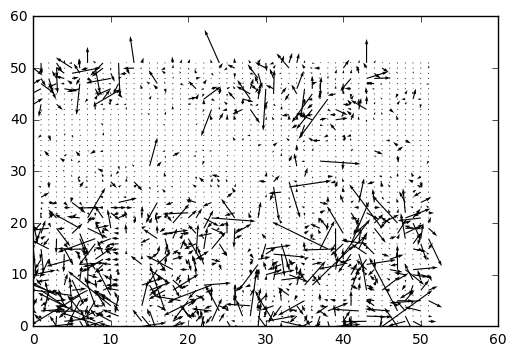

In [174]:
showFlow(frame1, frame2, 1, 10)

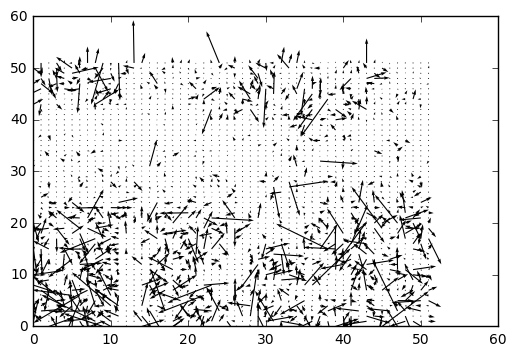

In [175]:
showFlow(frame1, frame2, 1, 100)

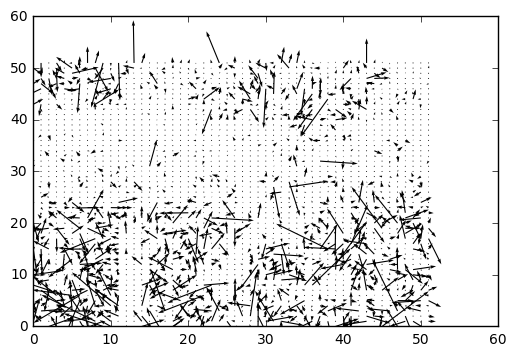

In [176]:
showFlow(frame1, frame2, 1, 500)

In [118]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

FILTER = 7
count = 0

def HS(im1, im2, alpha, ite,):

	#set up initial velocities
	uInitial = np.zeros([im1.shape[0],im1.shape[1]])
	vInitial = np.zeros([im1.shape[0],im1.shape[1]])

	# Set initial value for the flow vectors
	u = uInitial
	v = vInitial

	# Estimate derivatives
	[fx, fy, ft] = computeDerivatives(im1, im2)

	# Averaging kernel
	kernel=np.matrix([[1/12, 1/6, 1/12],[1/6, 0, 1/6],[1/12, 1/6, 1/12]])

	print fx[100,100],fy[100,100],ft[100,100]

	# Iteration to reduce error
	for i in range(ite):
		# Compute local averages of the flow vectors
		uAvg = cv2.filter2D(u,-1,kernel)
		vAvg = cv2.filter2D(v,-1,kernel)

		uNumer = np.multiply((np.multiply(fx, uAvg) + np.multiply(fy, vAvg) + ft), ft)
		uDenom = alpha + fx**2 + fy**2
		u = uAvg - np.divide(uNumer,uDenom)

		# print np.linalg.norm(u)

		vNumer = np.multiply((np.multiply(fx, uAvg) + np.multiply(fy, vAvg) + ft), ft)
		vDenom = alpha + fx**2 + fy**2
		v = vAvg - np.divide(vNumer,vDenom)
	return (u,v)

def computeDerivatives(im1, im2):
	# build kernels for calculating derivatives
	kernelX = np.matrix([[-1,1],[-1,1]])*.25 #kernel for computing dx
	kernelY = np.matrix([[-1,-1],[1,1]])*.25 #kernel for computing dy
	kernelT = np.ones([2,2])*.25

	#apply the filter to every pixel using OpenCV's convolution function
	fx = cv2.filter2D(im1,-1,kernelX) + cv2.filter2D(im2,-1,kernelX)
	fy = cv2.filter2D(im1,-1,kernelY) + cv2.filter2D(im2,-1,kernelY)
	# ft = im2 - im1
	ft = cv2.filter2D(im2,-1,kernelT) + cv2.filter2D(im1,-1,-kernelT)
	return (fx,fy,ft)

def smoothImage(img,kernel):
	G = gaussFilter(kernel)
	smoothedImage=cv2.filter2D(img,-1,G)
	smoothedImage=cv2.filter2D(smoothedImage,-1,G.T)
	return smoothedImage

def gaussFilter(segma):
	kSize = 2*(segma*3)
	x = range(-kSize/2,kSize/2,1+1/kSize)
	x = np.array(x)
	G = (1/(2*np.pi)**.5*segma) * np.exp(-x**2/(2*segma**2))
	return G

def compareGraphs():
	plt.ion() #makes it so plots don't block code execution
	plt.imshow(imgNew,cmap = 'gray')
	# plt.scatter(POI[:,0,1],POI[:,0,0])
	for i in range(len(u)):
		if i%5 ==0:
			for j in range(len(u)):
				if j%5 == 0:
					plt.arrow(j,i,v[i,j]*.00001,u[i,j]*.00001, color = 'red')
				pass
		# print i
	# plt.arrow(POI[:,0,0],POI[:,0,1],0,-5)
	plt.show()

#upload images# 
# directory = 'box/box.'
# # directory = 'office/office.'
# # directory = 'rubic/rubic.'
# # directory = 'sphere/sphere.'
# fileName = directory + str(count) + '.bmp'
# imgOld = cv2.imread(fileName,0)
# # imgOld = cv2.GaussianBlur(imgOld,(FILTER,FILTER),1)
# imgOld = smoothImage(imgOld,1)

# count += 1
# imgNew = cv2.imread(fileName,0)
# # imgNew = cv2.GaussianBlur(imgNew,(FILTER,FILTER),1)
# imgNew = smoothImage(imgNew,1)

frame1_smooth = smoothImage(frame1,1)
frame2_smooth = smoothImage(frame2,1)

# frame1_smooth = cv2.resize(frame1, (512,512))
# frame2_smooth = cv2.resize(frame2, (512,512))
flow = HS(frame1_smooth, frame2_smooth, 1, 100)


0 0 33


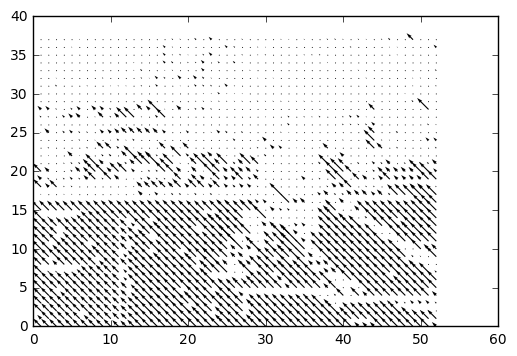

In [119]:
st2 = 10 # variable to reduce density of the vector field
Uf = np.flipud(flow[0][::st2, ::st2]) # horizontal optical flow
Vf = np.flipud(-flow[1][::st2, ::st2]) # vertical optical flow

Q = plt.quiver(Uf,Vf)
plt.show()

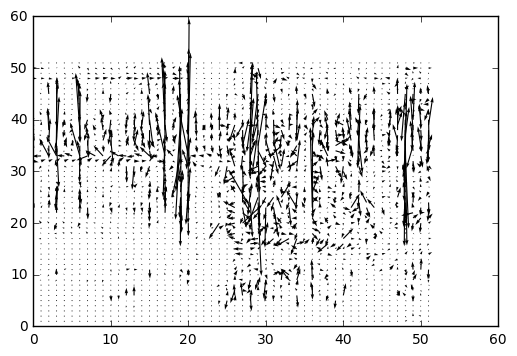

In [169]:
from scipy import signal
X_FILTER = [(-1, 1), (-1, 1)]
Y_FILTER = [(-1, -1), (1, 1)]
LAP_FILTER = [(0, 1/4, 0), (1/4, 0, 1/4), (0, 1/4, 0)]

def calcflowHS(frame1, frame2, alpha, k):
    # Calculate derivatives over images
    #   filter over each frame and sum them for change between frames
    fx = convolve2d(frame1, X_FILTER, boundary='symm', mode='same') + convolve2d(frame2, X_FILTER, boundary='symm', mode='same')
    fy = convolve2d(frame1, Y_FILTER, boundary='symm', mode='same') + convolve2d(frame2, Y_FILTER, boundary='symm', mode='same')
    ft = frame1 - frame2
    
    # Initialize flows at zero
    u = np.zeros((frame1.shape))
    v = np.zeros((frame1.shape))
    
    # Iterate until error measure specifies convergence
    #   (I am being lazy with the error measure for now and just performing a set num iterations)
    d = alpha + fx**2 + fy**2
    for i in range(k):
        #   Calculate averages across last iteration's estimate
        u_avg = signal.convolve2d(u, LAP_FILTER, boundary='symm', mode='same')
        v_avg = signal.convolve2d(v, LAP_FILTER, boundary='symm', mode='same')

        p = np.dot(fx, u_avg) + np.dot(fy, v_avg) + ft

        #   Calculate new estimates
        u = u_avg - np.dot(fx, np.divide(p, d))
        v = v_avg - np.dot(fy, np.divide(p, d))

    return (u, v)

frame1_smooth = cv2.resize(frame1, (512,512))/255.
frame2_smooth = cv2.resize(frame2, (512,512))/255.

flow = calcflowHS(frame1_smooth, frame2_smooth, 1, 100)
st2 = 10 # variable to reduce density of the vector field
Uf = np.flipud(flow[0][::st2, ::st2]) # horizontal optical flow
Vf = np.flipud(-flow[1][::st2, ::st2]) # vertical optical flow

Q = plt.quiver(Uf,Vf)
plt.show()